In [38]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from google.colab import files
from google.colab import drive
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

In [ ]:
# Mount Google Drive to save outputs
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load datasets (adjust file names as needed)
customers = pd.read_csv('/content/drive/MyDrive/Customers.csv')  # Replace with your actual filename
transactions = pd.read_csv('/content/drive/MyDrive/Transactions.csv')  # Replace with your actual filename
products = pd.read_csv('/content/drive/MyDrive/Products.csv')  # Replace with your actual filename

In [40]:
# Feature Engineering for Lookalike Model
def create_customer_features(customers, transactions, products):
    # Customer transaction features
    customer_stats = transactions.groupby('CustomerID').agg({
        'TotalValue': ['sum', 'mean', 'std'],
        'Quantity': ['sum', 'mean', 'std'],
        'TransactionID': 'count'
    }).fillna(0)

    # Flatten column names
    customer_stats.columns = ['_'.join(col).strip() for col in customer_stats.columns.values]

    # Category preferences
    transaction_products = transactions.merge(products, on='ProductID')
    category_pivot = pd.pivot_table(
        transaction_products,
        values='TotalValue',
        index='CustomerID',
        columns='Category',
        aggfunc='sum',
        fill_value=0
    )

    # Normalize category preferences
    category_pivot = category_pivot.div(category_pivot.sum(axis=1), axis=0)

    # Combine features
    customer_features = customer_stats.join(category_pivot)

    # Add customer region (one-hot encoded)
    region_dummies = pd.get_dummies(customers.set_index('CustomerID')['Region'], prefix='region')
    customer_features = customer_features.join(region_dummies)

    return customer_features

In [39]:
# Feature Importance Analysis using Random Forest
def feature_importance_analysis(customer_features, target_column='TotalValue_sum'):
    # Let's use a regression model to predict TotalValue_sum as an example
    X = customer_features.drop(target_column, axis=1)
    y = customer_features[target_column]

    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X, y)

    # Get feature importance and visualize it
    feature_importance = model.feature_importances_
    importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': feature_importance
    }).sort_values(by='Importance', ascending=False)

    # Plot feature importance
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['Feature'], importance_df['Importance'])
    plt.xlabel('Importance')
    plt.title('Feature Importance')
    plt.show()

    return importance_df

# Additional Validation Metrics using Silhouette Score
def clustering_validation(customer_features, n_clusters=5):
    # Apply KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(customer_features)

    # Calculate silhouette score
    silhouette_avg = silhouette_score(customer_features, cluster_labels)
    print(f"Silhouette Score for {n_clusters} clusters: {silhouette_avg}")

    return silhouette_avg

In [41]:
def find_lookalikes(customer_features, customer_id, n_recommendations=3):
    # Get similarity scores
    customer_vector = customer_features.loc[customer_id].values.reshape(1, -1)
    similarity_scores = cosine_similarity(customer_vector, customer_features)

    # Get top similar customers (excluding self)
    similar_indices = similarity_scores[0].argsort()[::-1][1:n_recommendations+1]
    similar_scores = similarity_scores[0][similar_indices]

    # Get customer IDs and scores
    similar_customers = customer_features.index[similar_indices]

    return list(zip(similar_customers, similar_scores))

In [42]:
# Create feature matrix
customer_features = create_customer_features(customers, transactions, products)


In [43]:
# Scale features
scaler = StandardScaler()
scaled_features = pd.DataFrame(
    scaler.fit_transform(customer_features),
    index=customer_features.index,
    columns=customer_features.columns
)


In [44]:
# Generate lookalikes for the first 20 customers
results = {}
for cust_id in customers['CustomerID'][:20]:
    lookalikes = find_lookalikes(scaled_features, cust_id)
    results[cust_id] = lookalikes


In [45]:
# Create output DataFrame
output_rows = []
for cust_id, recommendations in results.items():
    row = {
        'customer_id': cust_id,
        'lookalike_1': recommendations[0][0],
        'score_1': recommendations[0][1],
        'lookalike_2': recommendations[1][0],
        'score_2': recommendations[1][1],
        'lookalike_3': recommendations[2][0],
        'score_3': recommendations[2][1]
    }
    output_rows.append(row)

lookalike_df = pd.DataFrame(output_rows)


In [47]:
# Save results to CSV in Google Drive
output_path = '/content/drive/MyDrive/Lookalike.csv'
lookalike_df.to_csv(output_path, index=False)

print(f"Lookalike recommendations saved to: {output_path}")

Lookalike recommendations saved to: /content/drive/MyDrive/Lookalike.csv


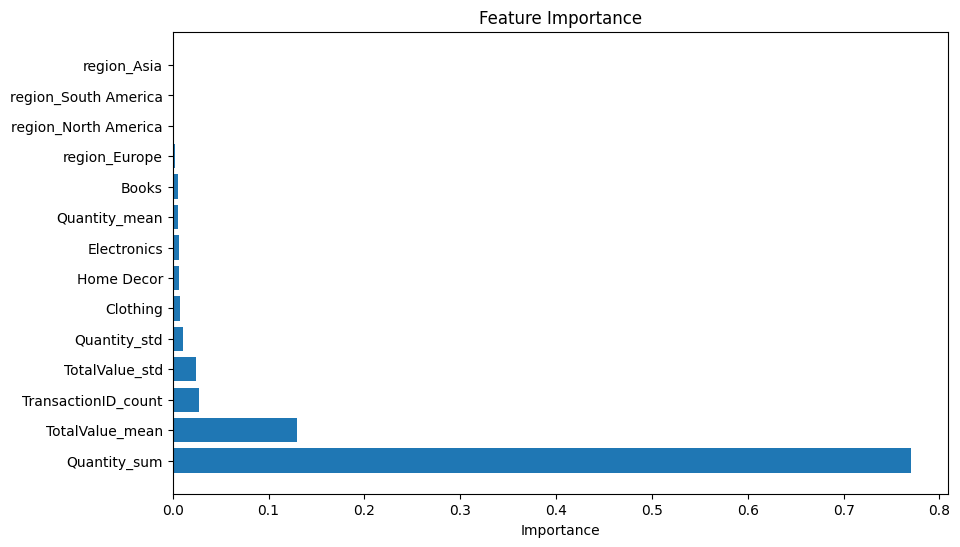

Feature Importance Analysis:
                 Feature  Importance
2           Quantity_sum    0.770095
0        TotalValue_mean    0.129430
5    TransactionID_count    0.027882
1         TotalValue_std    0.024137
4           Quantity_std    0.011214
7               Clothing    0.007861
9             Home Decor    0.006930
8            Electronics    0.006311
3          Quantity_mean    0.005944
6                  Books    0.005446
11         region_Europe    0.002016
12  region_North America    0.001329
13  region_South America    0.000842
10           region_Asia    0.000563
Silhouette Score for 5 clusters: 0.11066380507199992


0.11066380507199992

In [48]:
# Feature Importance Analysis
importance_df = feature_importance_analysis(customer_features)
print("Feature Importance Analysis:")
print(importance_df)

# Clustering Validation using Silhouette Score
clustering_validation(scaled_features, n_clusters=5)